# 1. Полносвязные нейронные сети.

# О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. **Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.**

# Загрузка датасета

https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [1]:
# для работы в Colaboratory
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-01-25 11:27:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  43.4MB/s    in 5.1s    

2022-01-25 11:27:22 (39.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [2]:
import pandas as pd
from sklearn.utils import shuffle

In [3]:
df = shuffle(pd.read_csv('data.txt.zip', header=None)) # shuffle делает перемешку данных, что очень хорошо для обучения

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
199819,2008,52.31572,25.65331,63.92982,12.93086,-5.53868,-28.10308,16.68181,-2.34175,9.42005,10.67936,1.41694,2.52639,9.46589,824.81578,606.65387,429.22998,537.68842,521.71846,403.22578,212.04430,439.03494,191.48093,137.79550,190.56972,-18.19693,-196.09505,45.53896,59.34009,59.45698,-103.39210,-3.97000,-39.45183,97.56431,-6.36303,24.11086,6.71022,-102.07476,188.92846,-89.21761,...,-132.97453,97.96461,-16.07365,-2.34379,1.73374,158.84280,-7.36220,-26.10690,124.59986,-137.41899,-24.73481,9.58659,-9.93229,-200.01489,-28.50208,68.56882,16.62197,76.90391,-16.88571,9.37474,76.57599,54.72917,9.38618,4.65981,14.78778,-0.82041,-354.55660,5.38977,-37.21364,81.36951,2.47280,-128.03208,16.11644,39.62206,4.32503,34.43946,6.45812,-2.58613,35.48773,-2.91692
40193,2000,46.06515,7.21136,-28.98266,3.71157,4.30196,-15.83251,1.56706,-0.45219,10.34263,1.02700,2.95862,-8.34081,19.42105,1105.62034,3853.44268,884.46071,901.96850,895.86886,726.80373,328.85660,205.34112,170.68899,190.67665,332.04202,20.92254,-555.10274,-296.48513,-14.98809,-74.53568,-50.54041,36.61621,24.82073,16.10164,6.96320,16.28932,69.29787,173.84957,758.06797,145.56143,...,56.76275,-38.23466,42.15414,-51.79519,-25.47286,290.68516,-544.58489,83.95372,-118.51622,-76.18157,-62.68113,24.97205,-1.12683,-266.86862,-399.26513,-15.20006,-67.65393,38.16706,162.71968,-16.05319,76.64386,-224.57867,29.55122,35.15585,11.86370,-13.74142,89.55174,-54.11423,136.60832,150.97269,21.52640,40.14775,5.87104,49.31252,2.86297,1.73626,16.09952,2.25697,-113.69342,-20.24605
384607,2007,41.74942,-54.35564,-27.59049,-22.59083,-16.03561,-3.55445,-6.54122,-9.71310,-9.06454,-16.03792,0.28576,12.74213,19.74872,1714.60836,1309.81873,1129.46949,538.00719,652.15248,566.82625,436.69731,320.99325,416.34644,185.10576,147.78780,39.43398,-695.58477,132.74999,-198.35290,-31.69889,20.15121,-30.66499,49.32915,-20.98824,-54.08084,3.13405,-23.11151,-471.52697,-193.08388,-313.59370,...,18.65235,-129.06656,15.22287,33.65053,20.75519,95.96658,-22.12056,-268.03528,125.85601,-182.51071,36.14726,-11.21323,-20.86118,-21.08352,15.02274,-147.73387,79.43757,33.15455,98.23604,45.12273,187.80486,-149.18952,166.38393,-17.00768,-49.49146,1.46750,88.57136,-8.34787,-89.94156,36.88856,26.30507,-1.56839,56.42561,-20.85193,0.42190,76.05443,-151.69910,6.12805,78.20921,10.83770
80050,2003,39.32505,4.13920,-18.74018,-16.51804,-32.79298,-8.50878,3.33611,-14.84803,13.81665,-0.16591,-2.72711,4.91285,10.71274,2094.28125,785.89702,1046.07361,966.49901,677.99030,415.19982,614.24654,460.59334,376.98761,261.78004,323.16459,34.13341,-227.36043,-24.85672,-73.88895,-104.02555,44.06398,31.00782,25.72540,3.47148,-42.42805,2.73805,49.67601,-216.31769,304.28575,-268.11957,...,57.67822,17.88098,35.58152,-106.71033,42.18643,222.08553,189.21951,-102.80971,296.48011,-188.23436,-28.62802,-33.28071,0.22517,-158.29413,127.14702,-41.94824,43.34368,97.72129,-21.84472,2.97619,-252.79070,116.98846,108.87636,-80.30656,9.87402,-4.18149,27.00578,167.01450,-207.71203,-213.62731,16.51766,-229.05802,-3.35927,66.19676,10.10029,132.09026,-140.51495,-3.82815,-83.72119,-13.52180
369799,1966,41.40957,-13.04261,32.24598,23.32230,-56.05745,8.45134,3.15521,-7.33681,-6.67488,0.30871,-4.64762,-4.67622,47.60982,1519.34518,2444.34211,1116.04024,670.95315,1128.22936,253.91150,479.11015,235.98105,238.60852,219.58121,151.92113,168.00665,573.92474,470.15256,-226.39521,-143.70312,141.12655,64.30480,-10.15127,-20.18975,5.25627,-26.88966,266.00454,181.35609,-695.18252,-57.39675,...,112.35721,15.44739,-83.99618,-13.10186,-38.66595,123.73334,-203.43776,-168.48421,87.60625,-16.58565,-4.89847,52.86113,61.65373,-101.01758,-606.42356,61.21909,40.85056,-16.69868,35.81013,-37.39763,-116.92667,133.61278,-9.78679,-9.97002,-24.69713,-68.27116,193.93402,-77.01119,-49.55266,44.6

In [5]:
X = df.iloc[:, 1:].values # убираем первый столбец, в котором у нас находятся года песен - признаки (90 штук признаков)
y = df.iloc[:, 0].values # стобец (вектор) c годами песен - Таргет

y_average = round(y.mean()) # средний арифмитический год из всех данных: для приближения таргета к 0

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size] - y_average
X_test = X[train_size:, :]
y_test = y[train_size:] - y_average

## Задание 0

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler().fit(X_train) # стандартизация или удаление среднего и масштабирование дисперсии

In [8]:
# scaler.mean_, scaler.scale_

In [9]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Масштабированные данные имеют нулевое среднее значение и единичную дисперсию:
X_train.mean(), X_train.std(), X_test.mean(), X_test.std()

(-2.301778900271797e-17,
 0.9999999999999996,
 -0.00011751278968604844,
 0.9908494396666676)

In [11]:
%%time
regr = Ridge(alpha=1.0) # регрессия Ридж
regr.fit(X_train, y_train) # обучаем модель
y_test_pred = regr.predict(X_test) # предсказание обученной модели для тестовой выборке
y_train_pred = regr.predict(X_train) # предсказание обученной модели для тренировочной выборки
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Test data: RMSE={rmse_test}")
print(f"Train data: RMSE={rmse_train}")

Test data: RMSE=9.619262968093793
Train data: RMSE=9.540401353054735
CPU times: user 736 ms, sys: 244 ms, total: 980 ms
Wall time: 639 ms


## Задание 1

In [12]:
import torch
from torch import nn
import numpy as np
import random
import math
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

### 1) Данные

In [13]:
# создаем класс Датасета для удобства итерирования данных (переопределяем готовый класс): в наш класс можно просто засунуть в качестве Х и у numpy массивы
class TensorDataset(TensorDataset):
    
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    
    def __len__(self):
        return self.X.size()[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [14]:
y_train

array([10,  2,  9, ...,  7,  2,  4])

In [15]:
y_train.reshape(-1,1)

array([[10],
       [ 2],
       [ 9],
       ...,
       [ 7],
       [ 2],
       [ 4]])

In [16]:
train_set = TensorDataset(X_train, y_train.reshape(-1,1)) 
test_set = TensorDataset(X_test, y_test.reshape(-1,1))

In [17]:
len(train_set), train_set[0]

(463715,
 (tensor([ 1.4705,  0.4724,  1.5668,  0.7215,  0.0445, -1.4440,  1.3089, -0.0691,
           0.5383,  1.3474,  0.3581, -0.0018, -1.0891, -0.9225, -1.0787, -0.9931,
          -0.7850, -0.6195, -0.6314, -0.9875,  0.2094, -0.8095, -0.8079, -0.6595,
          -0.5039, -0.3345,  0.1682,  0.3993,  0.2727, -1.0958, -0.0914, -0.8821,
           1.1808, -0.0411,  0.5552, -0.6105, -0.1223,  0.1568,  0.3853, -0.0178,
           0.4668,  1.3335, -0.1290, -0.2842, -0.3149, -0.1739, -0.2957, -0.1973,
           0.5487,  0.1205, -1.4860,  0.9273, -0.4122, -0.0488,  0.2071,  0.3456,
          -0.3604, -0.0976,  0.5066, -0.7589, -0.4704,  0.1885, -0.2515, -0.1996,
          -0.1250,  0.5329,  0.1342,  0.4225, -0.4575,  0.2769,  0.3394,  0.2172,
           0.2244,  0.2622,  0.5617,  0.1807, -1.2316, -0.1790,  0.3368,  0.4385,
          -0.4140, -0.3102, -0.2080,  0.0179,  0.2473,  0.1473,  0.1882, -0.5262,
           0.0839, -0.1912]),
  tensor([10.])))

In [18]:
# DataLoader позволяет автоматически подавать данные порциями (батчами)
# shuffle перемешка данных
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2, pin_memory=True) 
test_loader = DataLoader(test_set, batch_size=256, num_workers=2, pin_memory=True)

### 2) Функции и классы

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
           nn.Linear(90, 150),
           nn.ReLU(),
           nn.Linear(150, 150),
           nn.ReLU(),
           nn.Linear(150, 1)
        )
        
    def forward(self, x):
        return self.linear(x)

In [20]:
def set_random_seed(seed):
    
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [21]:
def plot_loss(train_loss, test_loss):
    
    clear_output()
    fig, ax = plt.subplots(figsize=(7, 4))
    plt.plot(range(1, len(train_loss)+1), train_loss, label='train')
    plt.plot(range(1, len(test_loss)+1), test_loss, label='test')
    plt.grid()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [22]:
def train(device, model, optimizer, criterion, train_loader, train_loss, count_epochs, epoch):
    
    running_loss = 0.0
    for data, labels in tqdm(train_loader, desc=f'Training {epoch} / {count_epochs}'):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        data = torch.flatten(data, start_dim=1)
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.shape[0]
    
    mse = running_loss / len(train_loader.dataset)
    train_loss += [math.sqrt(mse)]

    return train_loss

In [23]:
def test(device, model, criterion, test_loader, test_loss, count_epochs, epoch):
    
    running_loss = 0.0
    for data, labels in tqdm(test_loader, desc=f'Testing {epoch} / {count_epochs}'):
        data = data.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(data)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * data.shape[0]
    
    mse = running_loss / len(test_loader.dataset)
    test_loss += [math.sqrt(mse)]

    return test_loss

In [24]:
def learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs):
    
    train_loss, test_loss = [], []
    
    for epoch in range(1, count_epochs + 1):
        train(device, model, optimizer, criterion, train_loader, train_loss, count_epochs, epoch)
        test(device, model, criterion, test_loader, test_loss, count_epochs, epoch)
        plot_loss(train_loss, test_loss)
  
        print(f'epoch = {epoch}; RMSE: Train loss = {train_loss[-1]}, Test loss = {test_loss[-1]}')

    clear_output() 
    plot_loss(train_loss, test_loss)
    for i in range(len(train_loss)):
      print(f'epoch = {i}; RMSE: Train loss = {train_loss[i]}, Test loss = {test_loss[i]}')
    
    print(f'Average test loss: {np.average(test_loss)}')

### 3) Обучение

### 3.1) Необработанные данные

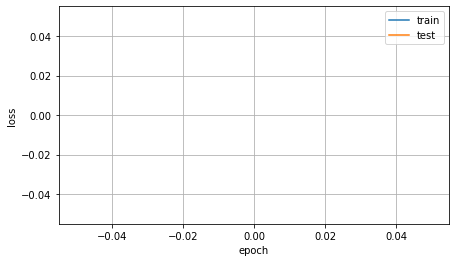

epoch = 0; RMSE: Train loss = nan, Test loss = nan
epoch = 1; RMSE: Train loss = nan, Test loss = nan


In [64]:
set_random_seed(101)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
count_epochs = 2
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

### 3.2) Игра в гиперпараметры (кальмара)

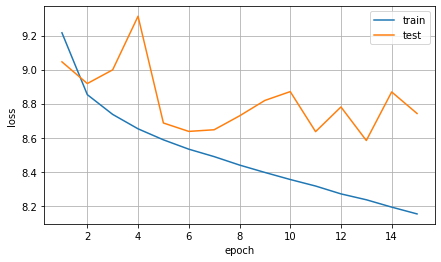

epoch = 15; RMSE: Train loss = 8.152587351130391, Test loss = 8.742184853337044


In [65]:
# batchsize = 32
# слои нейронки: 90 - 256 - 128 - 1
set_random_seed(101)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
count_epochs = 15
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

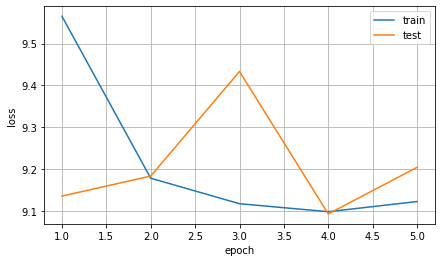

epoch = 9; RMSE: Train loss = nan, Test loss = nan


Training 10 / 10:   0%|          | 0/1812 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [26]:
set_random_seed(555)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = nn.MSELoss()
count_epochs = 10
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

### 3.3) Нейроночка работает что надо

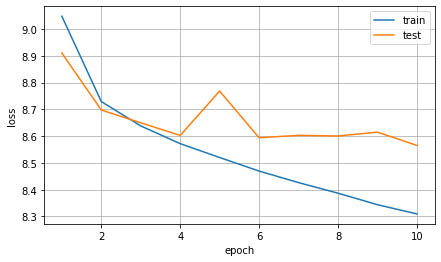

epoch = 0; RMSE: Train loss = 9.047902154428142, Test loss = 8.91064976162955
epoch = 1; RMSE: Train loss = 8.729337912436284, Test loss = 8.697681728263811
epoch = 2; RMSE: Train loss = 8.638316410394888, Test loss = 8.649909421602226
epoch = 3; RMSE: Train loss = 8.572092777559746, Test loss = 8.602673794717155
epoch = 4; RMSE: Train loss = 8.52017398034034, Test loss = 8.768374406846268
epoch = 5; RMSE: Train loss = 8.469682726552417, Test loss = 8.594069282599417
epoch = 6; RMSE: Train loss = 8.426534929156592, Test loss = 8.60308042186654
epoch = 7; RMSE: Train loss = 8.386957743264306, Test loss = 8.600675160122817
epoch = 8; RMSE: Train loss = 8.343988200422983, Test loss = 8.61487247554876
epoch = 9; RMSE: Train loss = 8.309588689041117, Test loss = 8.565575719834987


In [38]:
set_random_seed(111)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
count_epochs = 10
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

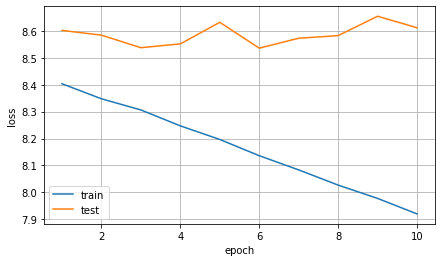

epoch = 0; RMSE: Train loss = 8.403673567160372, Test loss = 8.601955550492763
epoch = 1; RMSE: Train loss = 8.347767742423516, Test loss = 8.584412832026302
epoch = 2; RMSE: Train loss = 8.306232286613698, Test loss = 8.537718523977869
epoch = 3; RMSE: Train loss = 8.247058345469306, Test loss = 8.551845983413774
epoch = 4; RMSE: Train loss = 8.196481098841453, Test loss = 8.632164016722871
epoch = 5; RMSE: Train loss = 8.136077361071106, Test loss = 8.536088215450643
epoch = 6; RMSE: Train loss = 8.083288201646173, Test loss = 8.572864427928247
epoch = 7; RMSE: Train loss = 8.026755347551846, Test loss = 8.582569869121288
epoch = 8; RMSE: Train loss = 7.977244051805142, Test loss = 8.654680328335857
epoch = 9; RMSE: Train loss = 7.919562029124193, Test loss = 8.611799909646217


In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

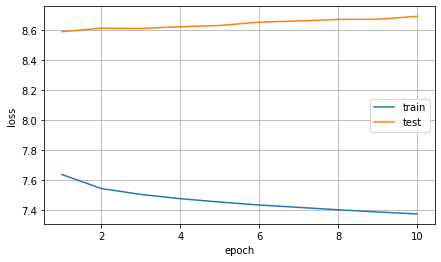

epoch = 0; RMSE: Train loss = 7.634835289218877, Test loss = 8.590469922258405
epoch = 1; RMSE: Train loss = 7.5412309065636505, Test loss = 8.613963601853305
epoch = 2; RMSE: Train loss = 7.501789767111331, Test loss = 8.61193471872022
epoch = 3; RMSE: Train loss = 7.473340051161948, Test loss = 8.623863888777596
epoch = 4; RMSE: Train loss = 7.450915034135557, Test loss = 8.631822900685844
epoch = 5; RMSE: Train loss = 7.431019890187137, Test loss = 8.65437750470383
epoch = 6; RMSE: Train loss = 7.415232798292541, Test loss = 8.66202263524904
epoch = 7; RMSE: Train loss = 7.399247283950521, Test loss = 8.672482709476105
epoch = 8; RMSE: Train loss = 7.384402825062257, Test loss = 8.673368999576953
epoch = 9; RMSE: Train loss = 7.371552217781367, Test loss = 8.693715441125763


In [40]:
set_random_seed(999)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
learning(device, model, optimizer, criterion, train_loader, test_loader, count_epochs)

## Задание 2

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**ОТЧЕТ**

В начале работы было очень больно, потому что ничего неработало. Далее ...
1) Сперва необходимо было все таки поработать с данными: не нужно было мне работать с чисто выходными данными. Нормировка признаков не давала ничего. Решение было найдено в том, чтобы привести все значения таргетов к значениям близким к нулю. Это уменьшило переобучение и качество метрики RMSE как оказалось в дальнейшем. Не помешало и то, что данные можно перетасовать и расположить в случайном порядке. Дальше все работала и меня это порадовало)
2) Подумала над архитектурой и поигралась с ней. Использовала обычную трехслойную нейронку. Единственное варьировала количество нейронов на промежуточных слоях. Большое количество нейронов выигрыша не давало, поэтому остановилась на 150 штуках. Использовала Стахонический спуск, и потом попробавала Adam. Эксперементы уже показывали, что желаемый результат мною достигнут. Поэтому дальше можно было остановится) lr - важнейший гиперпараметр для Стахонического спуска, поэтому именно его изменение привело к желаемому результату (0.05 сходиться не всегда, 0.005 сходиться) 
Также поигралась с seed, что дало некоторый результат 